In [256]:
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [257]:
def euclid_ccl(Omega_c, sigma8):

    cosmo_fid = ccl.Cosmology(Omega_c=Omega_c, Omega_b=0.045, h=0.71, sigma8=sigma8, n_s=0.963)
    nz = 1000
    z = np.linspace(0.0,3.,nz)
    pz = ccl.PhotoZGaussian(sigma_z0=0.05)
    dNdz_true = ccl.dNdzSmail(alpha = 1.3, beta = 1.5, z0=0.65)
    dNdzs = np.zeros((10, z.size))
    
    for i in range(10):
        zmin, zmax = i*0.2, (i+1)*.2
        dNdzs[i,:] = ccl.dNdz_tomog(z=z, zmin=zmin, zmax=zmax, pz_func=pz, dNdz_func = dNdz_true)
        # normalize each bin such that the integral is 1
        dNdzs[i,:] /=  dNdzs[i,:].sum()
    
    #ell = np.arange(100,5000)
    ell = np.logspace(np.log10(100),np.log10(6000),20)
    shears = []
    for i in range(10):
        
        gal_shapes = ccl.WeakLensingTracer(cosmo_fid, dndz=(z, dNdzs[i,:]))
        shears.append(gal_shapes)
    
    Cls = []
    for i in range(10):
        for j in range(0,i+1):
            Cls.append(ccl.angular_cl(cosmo_fid, shears[i], shears[j], ell))
     
    return ell, np.array(Cls), dNdzs

In [258]:
ells, Cls, dNdzs = euclid_ccl(0.27, 0.82)

In [259]:
Cls = np.array(Cls)

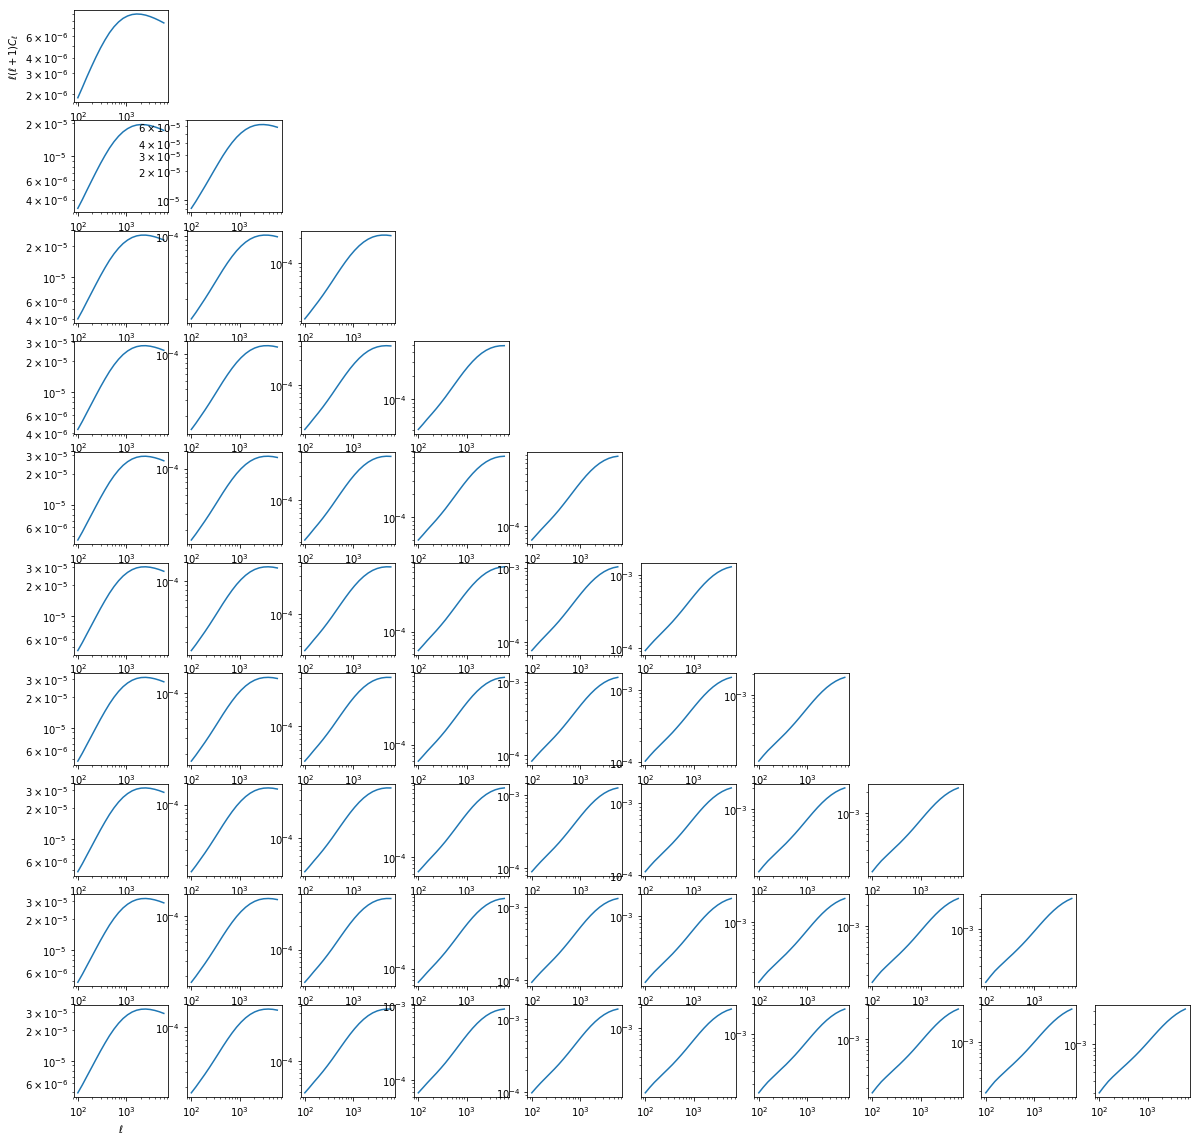

In [260]:
fig = plt.figure(figsize=(20,20))
counter = 0
for i in range(10):
        for j in range(0,i+1):
            ax = plt.subplot2grid((10,10), (i,j))
            ax.loglog(ells, ells*(ells+1)*Cls[counter])
            counter += 1
            
            if i == 0 and j == 0:
                ax.set_ylabel('$\ell  (\ell + 1) C_\ell$')
            if i == 9 and j == 0:
                ax.set_xlabel('$\ell$')
            

0.9999999999999999
1.0000000000000002
1.0
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0000000000000002


Text(0.5, 0, 'z')

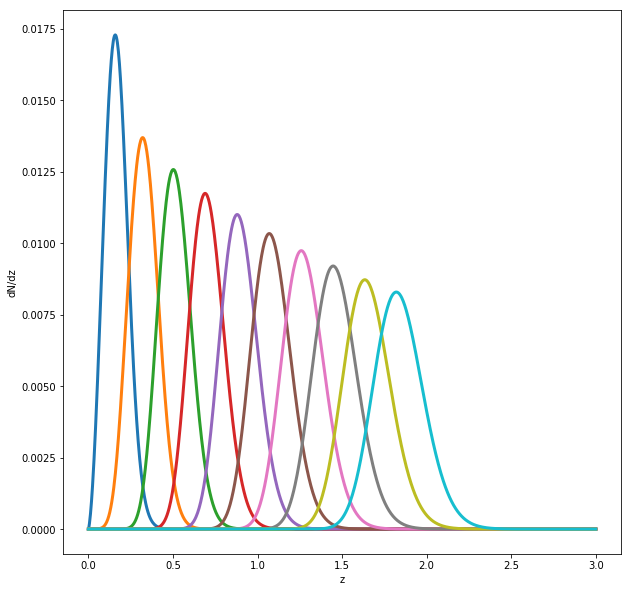

In [261]:
nz = 1000
z = np.linspace(0.0,3.,nz)
plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(z, dNdzs[i,:], lw = 3)
    print (dNdzs[i,:].sum())
    
plt.ylabel('dN/dz')
plt.xlabel('z')

In [262]:
def total_variance_Cls(i, j, m, n, nzs, ell_index, fsky, sn):
    '''fsky = fraction of sky, 15000/41252.96 for Euclid
    sn = shape noise = 0.3 ---> sn^2 = 0.3^2
    Cls = angular auto,cross power spectra
    nzs = array of number density values per tomographic bin
    '''
    ss_var_ij = (CL[i,m,ell_index]*CL[j,n,ell_index] + CL[i,n,ell_index]*CL[j,m,ell_index])/Nmode_per_l(ells[ell_index])   
    sn_var_ij = (CL[i,m,ell_index]*kroneker(j,n, sn) + kroneker(i,m, sn)*CL[j,n,ell_index]+ CL[i,n,ell_index]*CL[j,m,ell_index] + \
                 CL[i,n,ell_index]*kroneker(j,m,sn) + kroneker(i,n,sn)*CL[j,m, ell_index])/Nmode_per_l(ells[ell_index])
    nn_var_ij = (kroneker(i,m,sn)*kroneker(j,n,sn) + kroneker(i,n,sn)*kroneker(j,m,sn))/Nmode_per_l(ells[ell_index]) 
    
    return ss_var_ij + sn_var_ij + nn_var_ij
    
def Nmode_per_l(ell):
    
    return 1/(2*ell+1)/fsky

def kroneker(i,j, sn):
    
    if i == j :
        x = sn/nzs[i]
        return x
    else:
        return 0

In [263]:
CL = np.zeros((10,10, ells.size))
counter = 0
for i in range(10):
        for j in range(0,i+1):
            CL[i,j,:] = Cls[counter]
            counter += 1
for i in range(10):
    for j in range(10):
        CL[i,j,:] = CL[j,i,:]

In [264]:
def euclid_nzs(num_dens):
    '''euclid num density = 30 * 4pi/ arcmin^-2
    '''
    nz = 1000
    zmin , zmax = 0., 3.
    z = np.linspace(zmin, zmax,nz)
    pz = ccl.PhotoZGaussian(sigma_z0=0.05)
    dNdz_true = ccl.dNdzSmail(alpha = 1.3, beta = 1.5, z0=0.65)
    dNdz_obs = ccl.dNdz_tomog(z=z, zmin=zmin, zmax=zmax, pz_func=pz, dNdz_func = dNdz_true)
    # scale to the given number density
    dNdz_obs = dNdz_obs*num_dens/dNdz_obs.sum()
    nzs = []
    for i in range(10):
        zmin_i, zmax_i = i*.2 , (i+1)*.2
        mask = (z>zmin_i)&(z<zmax_i)
        nzs.append(dNdz_obs[mask].sum()) #*num_dens)
     
    return nzs

In [265]:
num_dens = 30 * 1/0.002777 # from arcmin^-2 to deg^-2
nzs = euclid_nzs(num_dens)
print (nzs)

[460.9917900560973, 1491.3751545106725, 1996.287005874856, 2024.597596157914, 1665.8877900168927, 1222.678170933661, 827.3872872622792, 500.7128234570089, 291.2972743728954, 154.45095304536352]


In [266]:
def cov_cls(ell_index):
    counter1 = 0
    counter2 = 0
    cov_cl = np.zeros((55,55))
    for m in range(10):
            for n in range(0,m+1):
                counter2 = 0
                for i in range(10):
                        for j in range(0,i+1):
                            cov_cl[counter1,counter2] = total_variance_Cls(i, j, m, n, nzs, ell_index, fsky, sn)
                            counter2 +=1
                counter1 += 1
                
    return cov_cl


In [267]:

fsky = 15000/41252.96
sn = 0.3
cov_cl_holder = []
for ell_index in range(len(ells)):
    cov_cl = np.array(cov_cls(ell_index))
    cov_cl_holder.append(cov_cl)
    
cov_cl_holder = np.array(cov_cl_holder)
# to keep a noise-free version of Cl as well
Cls_original = np.copy(Cls)
    
# only have to repeat these lines to add noise
Cls = np.copy(Cls_original)
for ell_index in range(len(ells)):
    # perturb CL with noise
    Cls[:,ell_index] += np.random.multivariate_normal(np.zeros(len(cov_cl)),cov_cl_holder[ell_index]) 


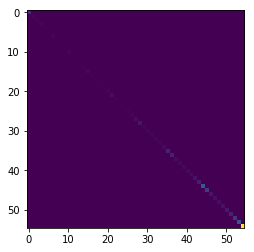

In [268]:
plt.imshow(cov_cl_holder[0])

In [269]:
print (np.shape(cov_cl_holder))
# check if matrix is symmetric
print (numpy.allclose(cov_cl_holder[0], cov_cl_holder[0].T, atol=np.min(cov_cl_holder)/10)) 

(20, 55, 55)
True


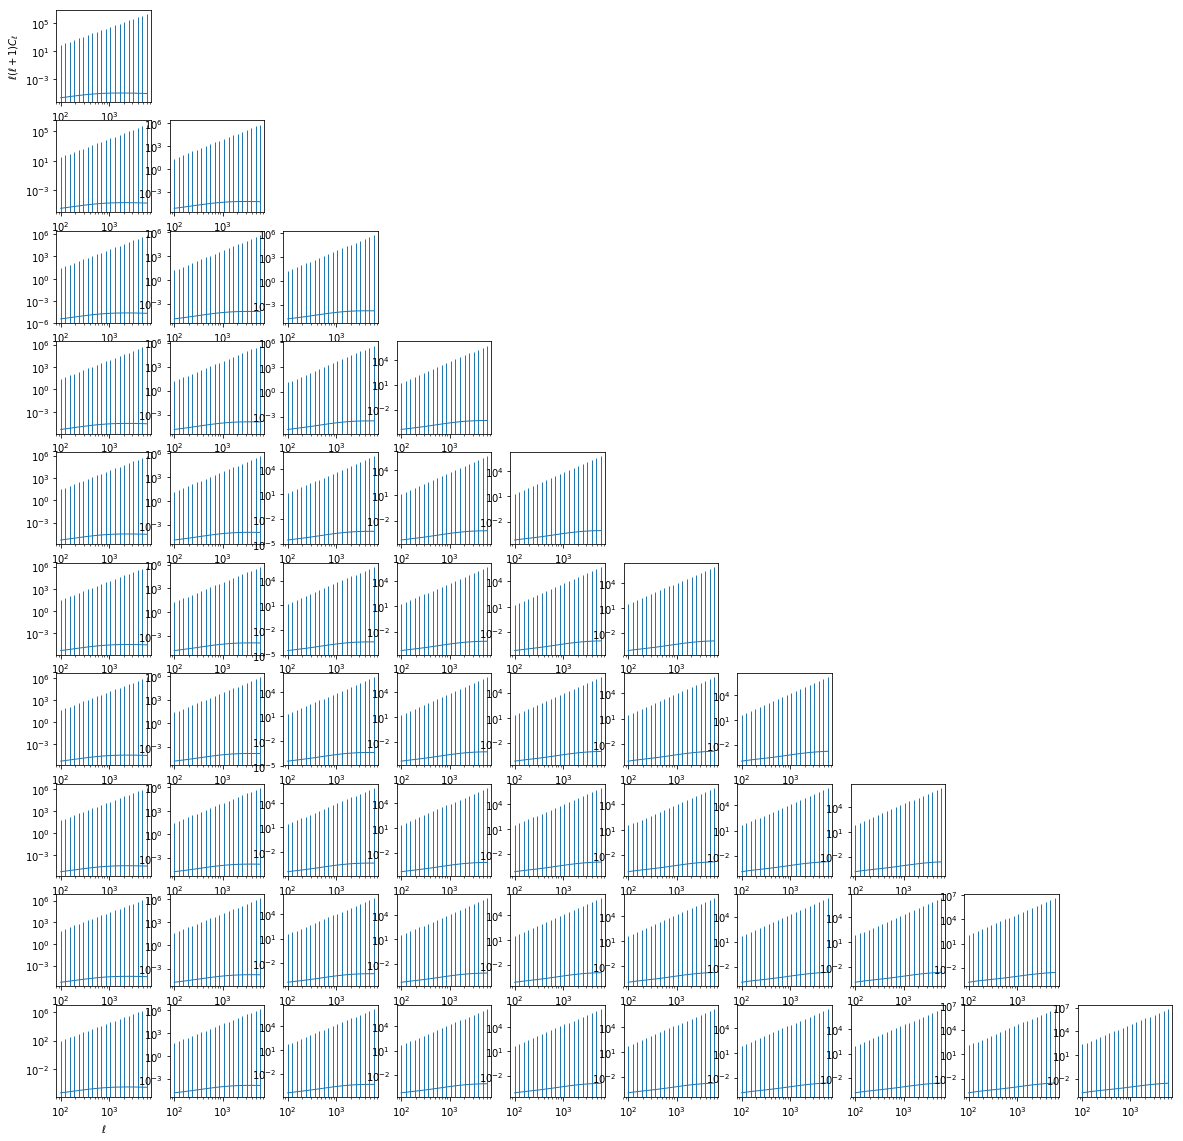

In [270]:
fig = plt.figure(figsize=(20,20))
counter = 0
for i in range(10):
        for j in range(0,i+1):
            ax = plt.subplot2grid((10,10), (i,j))
            # plot Cl vs ell
            # plot error as 1 sigma errorbar, diagonal terms only
            onesigma = np.sqrt(cov_cl_holder[:,counter,counter])
            ax.errorbar(ells, ells*(ells+1)*Cls_original[counter], yerr=ells*(ells+1)*onesigma,fmt='-',lw=1)
            ax.set_yscale('log')
            ax.set_xscale('log')
            if i == 0 and j == 0:
                ax.set_ylabel('$\ell  (\ell + 1) C_\ell$')
            if i == 9 and j == 0:
                ax.set_xlabel('$\ell$')
            
            counter += 1
            
plt.savefig('./c_ell_errorbars.pdf')
plt.savefig('./c_ell_errorbars.png')

            

[0.00243202 0.00270739 0.00301422 0.00335608 0.00373693 0.00416121
 0.00463384 0.00516032 0.00574677 0.0064     0.00712759 0.00793802
 0.00884068 0.00984608 0.01096589 0.01221313 0.0136023  0.01514952
 0.0168728  0.01879214]
[8.04335317e-10 6.19692701e-10 4.84288282e-10 3.78605237e-10
 2.97619274e-10 2.34455469e-10 1.83942049e-10 1.43517335e-10
 1.10204640e-10 8.31966747e-11 6.15743460e-11 4.44965763e-11
 3.14535032e-11 2.17223791e-11 1.46774221e-11 9.72870646e-12
 6.33750718e-12 4.07265117e-12 2.58831986e-12 1.62891640e-12]


<Figure size 1440x1440 with 0 Axes>

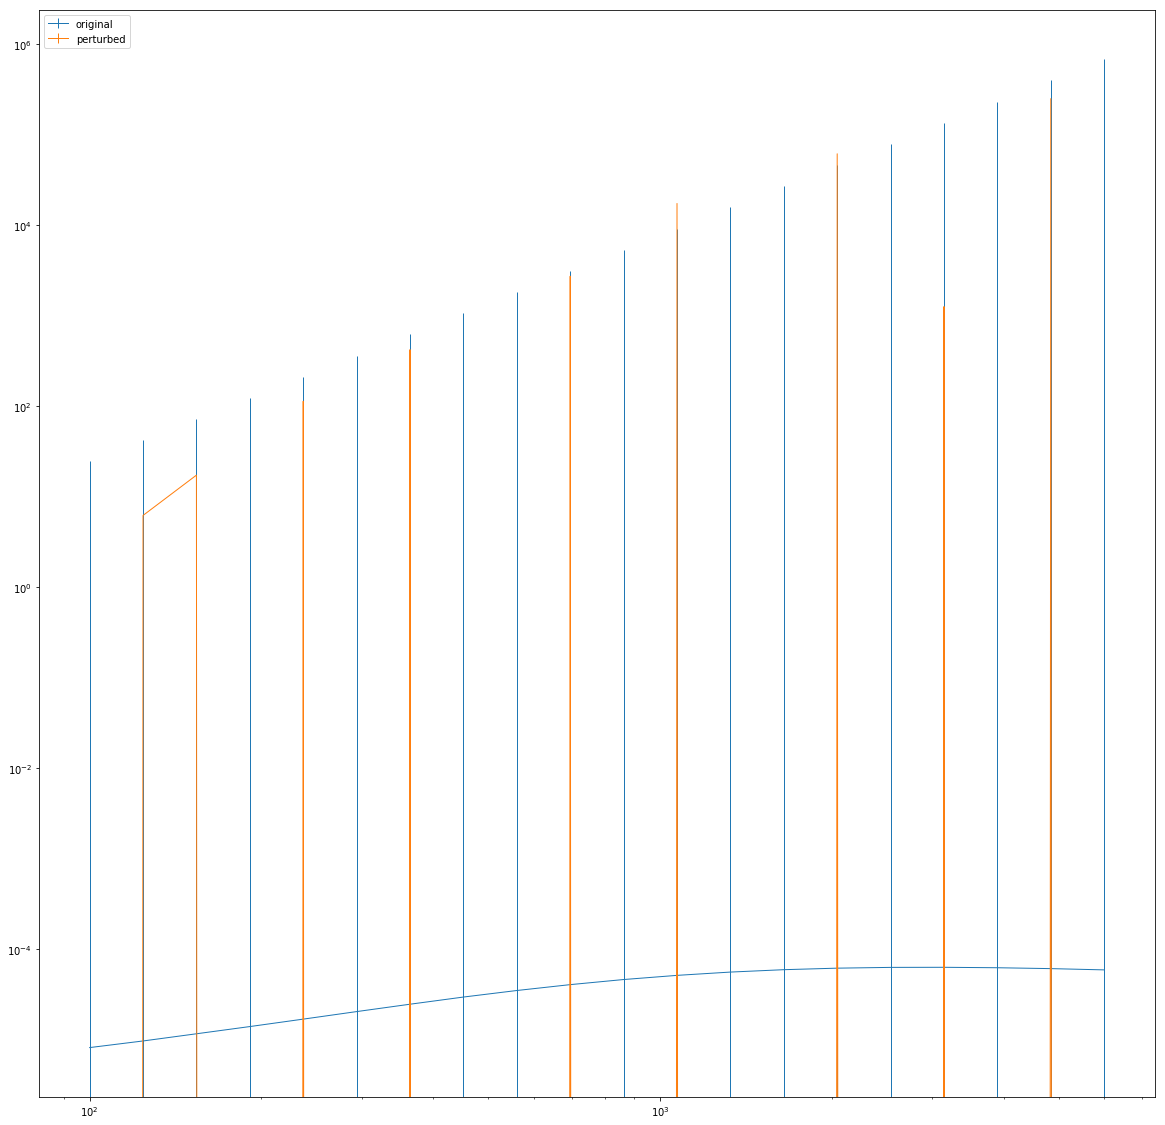

In [271]:
fig = plt.figure(figsize=(20,20))
i = 1
j = 1
counter = 2
fig, ax = plt.subplots(figsize=(20,20))
# plot Cl vs ell
# plot error as 1 sigma errorbar
onesigma = np.sqrt(cov_cl_holder[:,counter,counter])
print (onesigma)
print (Cls_original[counter])
ax.errorbar(ells, ells*(ells+1)*Cls_original[counter], yerr=ells*(ells+1)*onesigma, fmt='-', lw=1,label='original')
ax.errorbar(ells, ells*(ells+1)*Cls[counter], yerr=0, fmt='-', lw=1, label='perturbed')
ax.set_yscale('log')
ax.set_xscale('log')
plt.legend(loc='upper left')





In [272]:
print ('Testing purposes')

Testing purposes


In [273]:
# repeat the story but split the 3 terms of the covariance
# to identify where it is going wrong

def total_variance_Cls_split(i, j, m, n, nzs, ell_index, fsky, sn):
    '''fsky = fraction of sky, 15000/41252.96 for Euclid
    sn = shape noise = 0.3 ---> sn^2 = 0.3^2
    Cls = angular auto,cross power spectra
    nzs = array of number density values per tomographic bin
    '''
    ss_var_ij = (CL[i,m,ell_index]*CL[j,n,ell_index] + CL[i,n,ell_index]*CL[j,m,ell_index])/Nmode_per_l(ells[ell_index])   
    sn_var_ij = (CL[i,m,ell_index]*kroneker(j,n, sn) + kroneker(i,m, sn)*CL[j,n,ell_index]+ CL[i,n,ell_index]*CL[j,m,ell_index] + \
                 CL[i,n,ell_index]*kroneker(j,m,sn) + kroneker(i,n,sn)*CL[j,m, ell_index])/Nmode_per_l(ells[ell_index])
    nn_var_ij = (kroneker(i,m,sn)*kroneker(j,n,sn) + kroneker(i,n,sn)*kroneker(j,m,sn))/Nmode_per_l(ells[ell_index]) 
    
    return ss_var_ij, sn_var_ij, nn_var_ij

In [274]:
# repeat the story but split the 3 terms of the covariance

def cov_cls_split(ell):
    counter1 = 0
    counter2 = 0
    cov_cl_SS = np.zeros((55,55))
    cov_cl_SN = np.zeros((55,55))
    cov_cl_NN = np.zeros((55,55))
    
    for m in range(10):
            for n in range(0,m+1):
                counter2 = 0
                for i in range(10):
                        for j in range(0,i+1):
                            cov_cl_SS[counter1,counter2], cov_cl_SN[counter1,counter2], cov_cl_NN[counter1,counter2] = total_variance_Cls_split(i, j, m, n, nzs, ell_index, fsky, sn)
                            counter2 +=1
                counter1 += 1
                
    return np.array(cov_cl_SS), np.array(cov_cl_SN), np.array(cov_cl_NN)

In [275]:
# repeat the story but split the 3 terms of the covariance
cov_cl_holder_SS = []
cov_cl_holder_SN = []
cov_cl_holder_NN = []

for ell_index in range(len(ells)):
    # (55,55) arrays
    cov_cl_SS, cov_cl_SN, cov_cl_NN = cov_cls_split(ell_index)
    
    cov_cl_holder_SS.append(cov_cl_SS)
    cov_cl_holder_SN.append(cov_cl_SN)
    cov_cl_holder_NN.append(cov_cl_NN)
    
    
cov_cl_holder_SS = np.array(cov_cl_holder_SS)
cov_cl_holder_SN = np.array(cov_cl_holder_SN)
cov_cl_holder_NN = np.array(cov_cl_holder_NN)


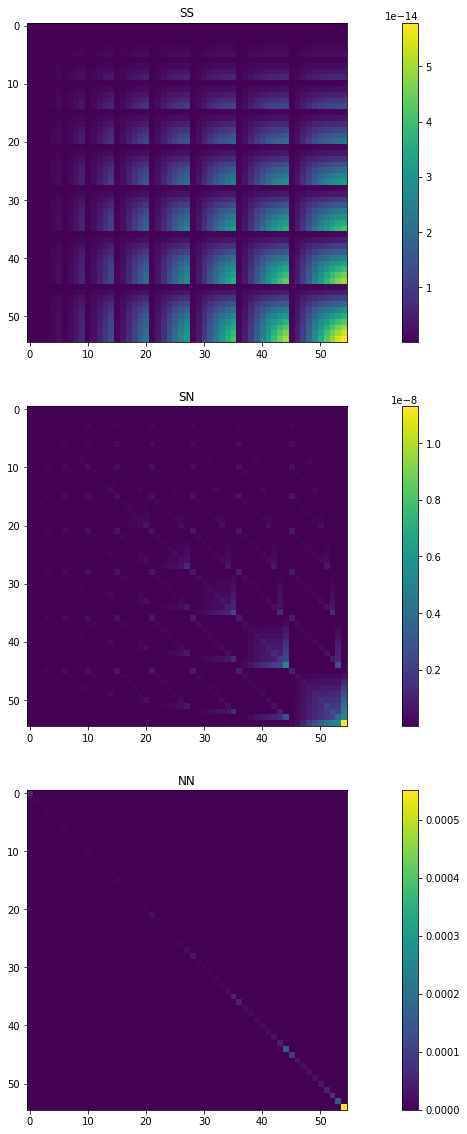

In [278]:
fig, axes = plt.subplots(3,1,figsize=(20,20))
cf = axes[0].imshow(cov_cl_holder_SS[0])
axes[0].set_title('SS')
fig.colorbar(cf, ax=axes[0])

cf = axes[1].imshow(cov_cl_holder_SN[0])
axes[1].set_title('SN')
fig.colorbar(cf, ax=axes[1])

cf = axes[2].imshow(cov_cl_holder_NN[0])
axes[2].set_title('NN')
fig.colorbar(cf, ax=axes[2])

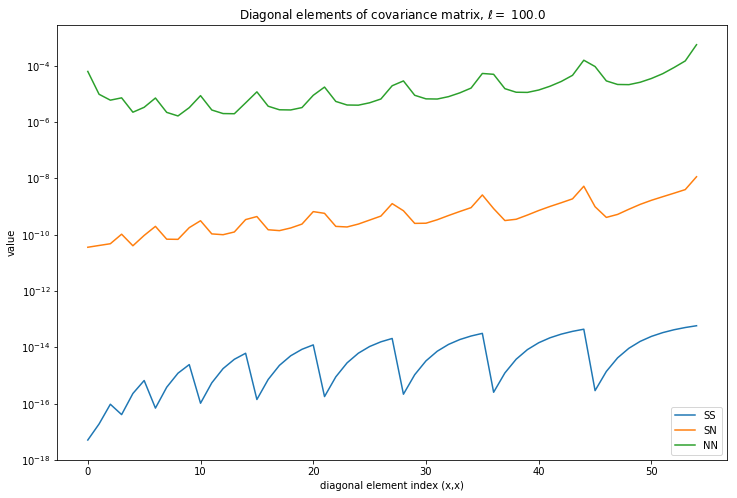

In [277]:
ell_index = 0
fig = plt.figure(figsize=(12,8))
plt.plot(np.diagonal(cov_cl_holder_SS[ell_index]),label='SS')
plt.plot(np.diagonal(cov_cl_holder_SN[ell_index]),label='SN')
plt.plot(np.diagonal(cov_cl_holder_NN[ell_index]),label='NN')
plt.xlabel('diagonal element index (x,x)')
plt.ylabel('value')
plt.yscale('log')
plt.title('Diagonal elements of covariance matrix, $\ell = $ %s'%str(ells[ell_index]))
plt.legend()
plt.savefig('./variances_separated.png')

